# 4.4 Random Snake Experiment

The goal is to understand what a ranking learns in a skilled based scheduler. Conceptually, I do not see what information there is in a perfectly balanced game. I say none. I say there is nothing to learn. If you toss a fair coin with friends, you do not draw any conclusions. Maybe after ten losses, you start to believe that the coin is biased, or your opponent is a cheater. But a head or tail says nothing.

The idea in the random snake setup is to present, to a ranking, games that are assumed to be fair and are indeed fair. 
It is a conceptual setup. It makes no sense to organize a tournament of coin toss. Likewise, it makes no sense to speak about skilled base matchmaking for a game with no skill, and certainly no one would build a ranking from such a dataset. But I invite readers, to think about it. What do you believe a ranking means in this context? What metric would you track? I invite the readers to make a guess. How does your favorite ranking algorithm behave in this setting?

You can set to True the anonymizine parameters. The experimental results will be displayed with aliases for each rankings. The end of the notebook includes a discussion about the differences.

In [1]:
ANONYMIZE = True


## 4.4.2 Protocol
I perform a comparative study on Elo, Glicko, TrueSkill and Openskill (PlackttLuce). The metric of evaluation is rank correlation with a win rate based ranking. The simulation parameters are the following ones:
- players: 64 players
- game type: one-versus-one
- Scheduler: Snake (Skilled-based matchmaking-like tournament)
- Solver: FlipCoin (player level does not matter, pure random results)
  
For each ranking I perform an RSSC run of depth 500. At different time of the simulation t=0, 5, 10, 50, 100, 200, 500, for each player, I measure the total number of wins, the win rate in career, and the win rate over the last 50 played games. This serves as references to compute three different "ground truth" rankings. During the RSSC loop the state21 of the ranking is stored after each update, i.e. after each Snake edition.


In [2]:
from rstt import WinRate, Ranking, Player, CoinFlip, Snake
from utils.commons import rankings, PlayerWins
from utils import rssc
import rstt.config as cfg

import random

# Players
population = Player.create(nb=64)

# Solver
toss = CoinFlip()

# Scheduler
scheduler = Snake

# Tests Ranking
test_rankings = rankings(population)
if ANONYMIZE:
    random.shuffle(test_rankings)
    tests_rankings = {f'Algo {i+1}': ranking for i, ranking in enumerate(test_rankings)}
else:
    tests_rankings = {ranking.name: ranking for i, ranking in enumerate(test_rankings)}


# Groundtruth - player need to track their games
cfg.DUEL_HISTORY = True

def career(ranking: Ranking):
    return WinRate(name=f'{ranking.name} - Career Win Rate', players=ranking.players())
    
def recent(ranking: Ranking):
    return WinRate(name=f'{ranking.name} - Win Rate', scope=50, players=ranking.players())

def wins(ranking: Ranking):
    return PlayerWins(name=f'{ranking.name} - Win Rate', players=ranking.players())

# depth
depth = 500

# moments
moments = [0, 5, 10, 50, 100, 200, 500]

In [3]:
from rstt.stypes import SPlayer

from functools import partial
from dataclasses import dataclass

from utils.metrics import ktcorr


@dataclass
class RankingPoints:
    points: dict[SPlayer, float]
    career: dict[SPlayer, float]
    recent: dict[SPlayer, float]
    wins: dict[SPlayer, float]

def track_performances(ranking: Ranking, cwr: Ranking, rwr: Ranking, tw: Ranking, *args, **kwargs) -> RankingPoints:
    cwr.update()
    rwr.update()
    tw.update()
    return RankingPoints(
        points = {p: ranking.point(p) for p in ranking},
        career = {p: cwr.point(p) for p in ranking},
        recent = {p: rwr.point(p) for p in ranking},
        wins = {p: tw.point(p) for p in ranking}
    )


results = {}
for algo, ranking in tests_rankings.items():
    # reset game history
    [p.reset() for p in population]
    
    # new ranking history
    perf = partial(track_performances, cwr=career(ranking), rwr=recent(ranking), tw=wins(ranking))
    results[algo] = [perf(ranking)]
    
    # rssc simulation
    results[algo] += (rssc(name=f'Random Snake - {algo}', seed=ranking, cup=scheduler, solver=toss, depth=depth, metric=perf))

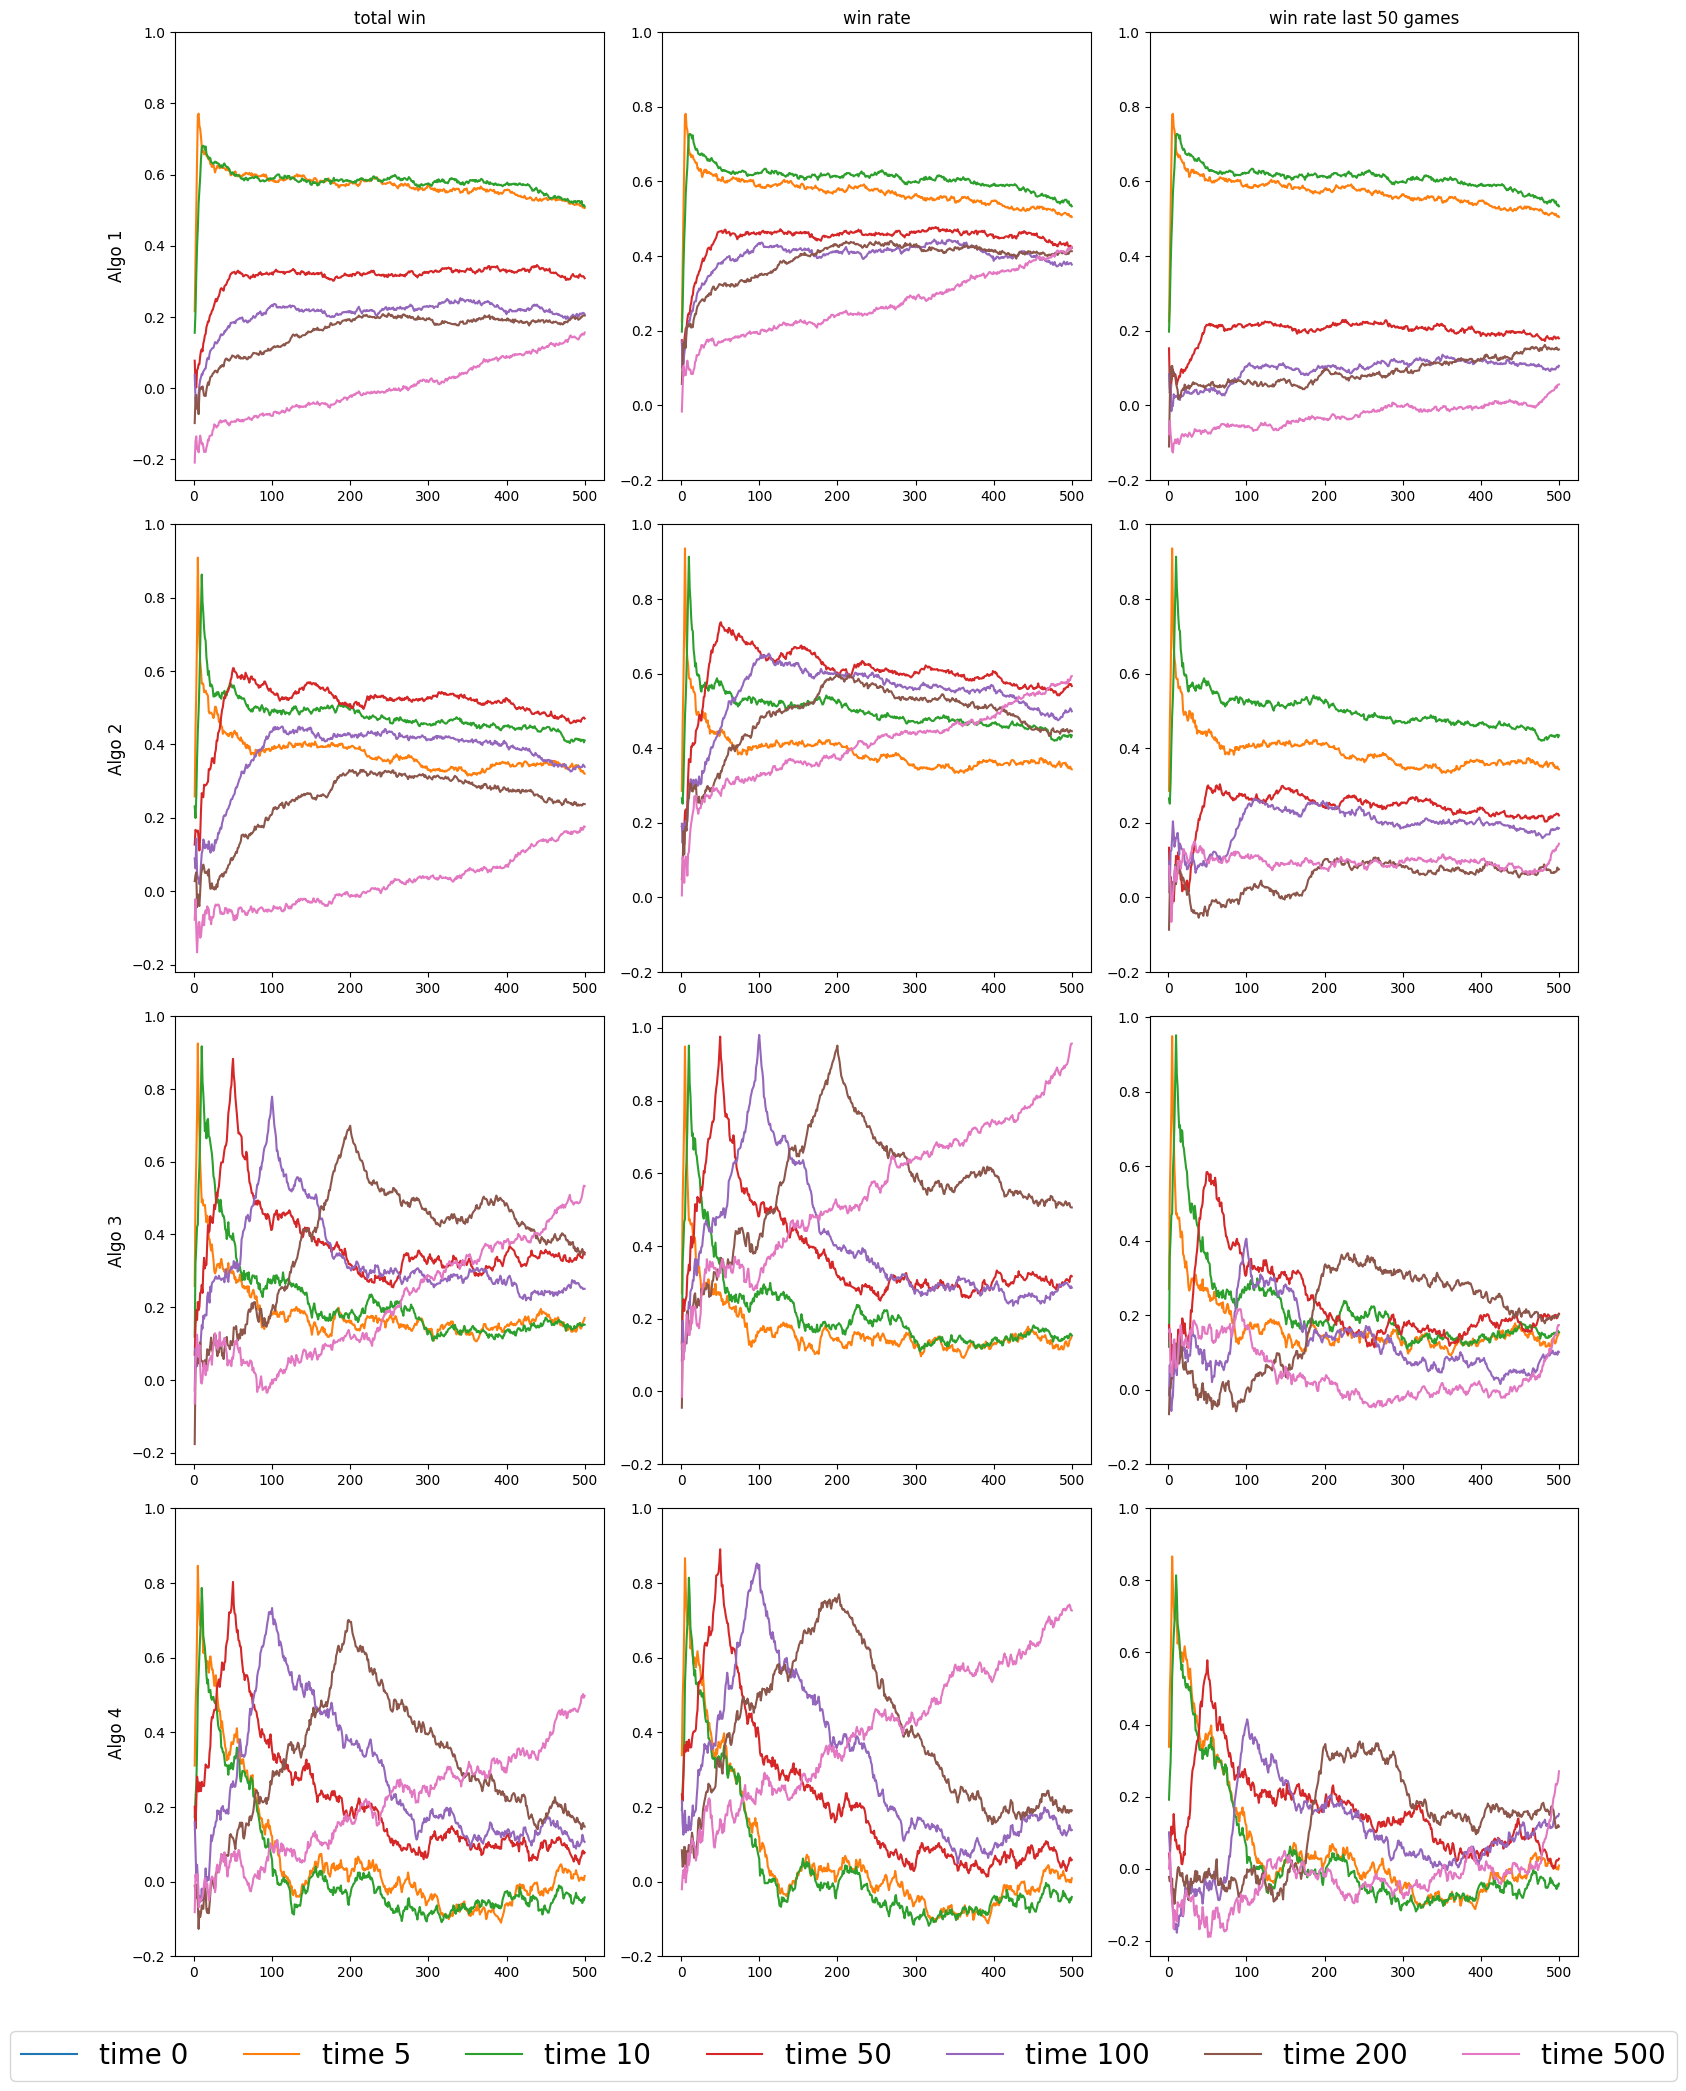

In [4]:
import matplotlib.pyplot as plt
from scipy import stats

import numpy as np

corrs = {}
rows = list(results.keys())
cols = ['total win', 'win rate', 'win rate last 50 games']
x = list(range(depth+1))


nr = len(rows)
nc = len(cols)

fig, axs = plt.subplots(nr, nc, figsize=(nc*5, nr*5))

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,], rows):
    ax[0].set_ylabel(row, rotation=90, size='large')
    
    careers = [[results[row][m].career[p] for p in population] for m in moments]
    recents = [[results[row][m].recent[p] for p in population] for m in moments]
    totalwins = [[results[row][m].wins[p] for p in population] for m in moments]

    refs = [totalwins, careers, recents]

    for a, ref in zip(ax, refs):
        for m, r in zip(moments, ref):
            corrs = [stats.kendalltau(r, [result.points[p] for p in population]).statistic for result in results[row]]
            a.plot(x, corrs, label=f'time {m}')
            a.set_xticks(range(0, depth+1, 100))
            a.set_yticks(np.arange(-0.2, 1.01, 0.2))
        
# legend
lines, labels = axs[0][0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncols=7, bbox_to_anchor=(0.5, -0.05), fontsize=20)
fig.tight_layout()

## 4.4.3 Results
From a far distance, we can see in figure 4.7 that Elo and Glicko behave similarly, chaotic lines crossing each other multiple times. TrueSkill and PlackettLuce have more straight lines and fewer crossing.


At any point of the simulation, Elo and Glicko have a high rank correlation with the current win rate of the players. The ranking does not converge, it continuously changes. As time passes, it reaches close to 0 rank correlation with its prior states. In a random game, ’skill’ means luck.

Regarding TrueSkill and PlackettLuce, the rankings do not change over time. They converged to a state. Onward, the state barely evolves. In skilled based matchmaking and perfectly balanced game, the ranking state is not altered.

In my eyes, both behaviors are reasonable. Exploring every possible ranking state because there is no ranking is acceptable. It means every state is equally ’true/likely’, fair enough. And for the second, like I said, in my mind there is no information in a skilled based matchmaking, so the ranking state should not change. This is perhaps the greatest contribution of my thesis: A conceptual test that shows qualitative (not quantitative) differences between well-known ranking techniques. Usually we can read comments like A converges faster than B, C does better prediction than D etc. Here we can answer the question: What do they do ?

But there is one thing that bothers me a lot. The state OpenSkill and TrueSkill adopt is not one where players all have the same level. The state the TrueSkill and PlackettLuce adopt is the initial luck. There is no reason to converge initially; the matchmaking quality has not changed. The players’ levels did not evolve. After players have each participated in 500 games and more, they are still ranked the same way they were after approximately 10. Why bother playing

In [5]:
for ano, ranking in tests_rankings.items():
    print(ano,' -> ' , ranking.name)

Algo 1  ->  Trueskill
Algo 2  ->  OS - PlackettLuce
Algo 3  ->  Elo - GBG
Algo 4  ->  Gliko - Batch
